# Introduction

This script aims to improve my competition score, not by introducing more complicated models but by doing a better job in data cleaning. As well as previous data cleaning the following steps will be taken.

1. Log transform of the response variable (as there is evidence of non constant variance of error terms by previous residual plots).
2. Improved imputation of missing values. Previous the mean of the feature was used, here I try to group observations by some common characteristics and make a more educated guess at imputing missing values.
3. Check for and possibly remove outliers and high leverage points.
4. Introduction of interaction and non linear terms.

In [1515]:
# packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.stats import norm, skew


plt.style.use('ggplot')

In [1516]:
# load data & preview data
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

display(df_train.tail())
print(df_train.shape)
display(df_test.head())
print(df_test.shape)

# np.savetxt("../cleaned_data/list_cols.csv", list(df_train.columns), delimiter=",", fmt='%s')


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


(1459, 80)


# Log Transformations

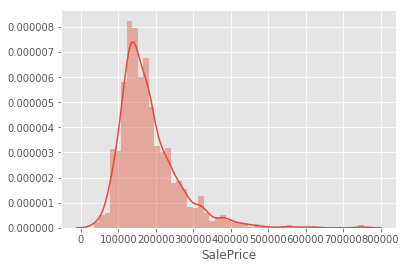

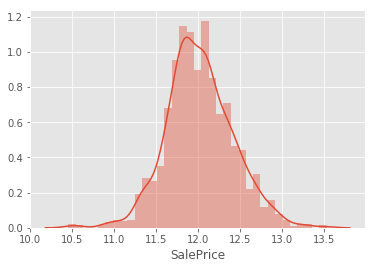

In [1517]:
sns.distplot(df_train['SalePrice'])
plt.show()
# log transform dependent variable

df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

sns.distplot(df_train['SalePrice'])
plt.show()

In [1518]:
# combine train and test sets and preview.
df_combined = pd.concat([df_train.drop('SalePrice', axis = 1), df_test]).reset_index().drop('index', axis = 1)
display(df_combined.tail())

print(df_combined.shape)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2918,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


(2919, 80)


# Impute Missing Values

In [1519]:
# check for missing values.
total = df_combined.isnull().sum().sort_values(ascending=False)
percent = (df_combined.isnull().sum()/df_combined.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [1520]:
# create dictionary for converting quality variables to numerical.
conv_dict={'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5, np.NaN: 0}

      PoolArea  PoolQC
197        512       5
810        648       2
1170       576       4
1182       555       5
1298       480       4
1386       519       2
1423       738       4
1974       144       5
2420       368       3
2503       444       3
2573       228       5
2599       561       3
2710       800       4


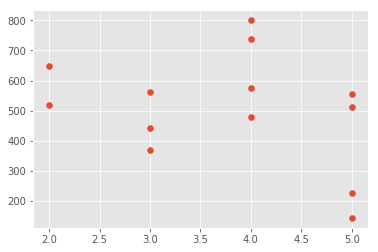

In [1521]:
# Pools
df_combined['PoolQC'] = df_combined['PoolQC'].fillna('TA')
df_combined['PoolQC'] = df_combined['PoolQC'].apply(conv_dict.get)

pools = df_combined[df_combined['PoolArea'] > 0]
pools = pools[['PoolArea', 'PoolQC']]
print(pools)

# we can see there are 13 pool areas given, but quality is only given for 10.
plt.scatter(pools['PoolQC'], pools['PoolArea'])
plt.show()

# there seems to be no relationship between pool size and pool quality.
# therefore we will fill missing pool quality values with TA

In [1522]:
# Msc Feature
df_combined['MiscFeature'] = df_combined['MiscFeature'].fillna('None')
print(df_combined['MiscFeature'].value_counts()) 
print(df_combined['MiscVal'].value_counts())

# it seems reasonable that missing values for misc feature just indicates that there is no misc featuers.

None    2814
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64
0        2816
400        18
500        13
450         9
600         8
700         7
2000        7
650         3
1200        3
1500        3
4500        2
2500        2
480         2
3000        2
12500       1
300         1
350         1
8300        1
420         1
80          1
54          1
460         1
490         1
3500        1
560         1
17000       1
15500       1
750         1
800         1
900         1
1000        1
1150        1
1300        1
1400        1
1512        1
6500        1
455         1
620         1
Name: MiscVal, dtype: int64


In [1523]:
# Alley
df_combined['Alley'] = df_combined['Alley'].fillna('None')
print(df_combined['Alley'].value_counts())
# Again it seems reasonable that missing values for alley indicates no alley is present.

None    2721
Grvl     120
Pave      78
Name: Alley, dtype: int64


In [1524]:
# Fence
df_combined['Fence'] = df_combined['Fence'].fillna('None')
print(df_combined['Fence'].value_counts())
# same as above

None     2348
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64


In [1525]:
# Fireplace quality
print(df_combined['FireplaceQu'].value_counts())
print(df_combined['Fireplaces'].value_counts())

df_combined['FireplaceQu'] = df_combined['FireplaceQu'].apply(conv_dict.get)

# The number of missing values for fireplace quality matches the number of houses with 0 fireplaces indicated.

Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: FireplaceQu, dtype: int64
0    1420
1    1268
2     219
3      11
4       1
Name: Fireplaces, dtype: int64


In [1526]:
# lot frontage (Linear feet of street connected to property)
# print(df_combined['LotFrontage'].value_counts())

# missing values could indicate property is on the street.
df_combined["LotFrontage"] = df_combined.groupby("Neighborhood").transform(lambda x: x.fillna(x.median()))['LotFrontage']


In [1527]:
# Garages
# we can see that there are 159 entries with missing info for various garage 
# there are 157 missing values for another garage variable.

no_garage = df_combined[df_combined['GarageCond'].isna()]
no_garage = no_garage[['Id','GarageCond', 'GarageQual', 'GarageArea',  'GarageType', 'GarageYrBlt', 'GarageFinish']]

# display(no_garage)
garage = no_garage[no_garage['GarageType'].notna()]
display(garage)


garage_cols = ['GarageCond', 'GarageQual', 'GarageType', 'GarageFinish']

for col in garage_cols:
    display(df_combined[col].value_counts())
    print("-" * 70)

,Id,GarageCond,GarageQual,GarageArea,GarageType,GarageYrBlt,GarageFinish
2126,2127,NaN,NaN,360.0,Detchd,NaN,NaN
2576,2577,NaN,NaN,NaN,Detchd,NaN,NaN


TA    2654
Fa      74
Gd      15
Po      14
Ex       3
Name: GarageCond, dtype: int64

----------------------------------------------------------------------


TA    2604
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64

----------------------------------------------------------------------


Attchd     1723
Detchd      779
BuiltIn     186
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64

----------------------------------------------------------------------


Unf    1230
RFn     811
Fin     719
Name: GarageFinish, dtype: int64

----------------------------------------------------------------------


In [1528]:
# manully fill data with missing value for some garage variable but not for other.

df_combined['GarageCond'].iloc[2126] = 'TA'
df_combined['GarageQual'].iloc[2126] = 'TA'
df_combined['GarageFinish'].iloc[2126] = 'Unf'
df_combined['GarageYrBlt'].iloc[2126] = df_combined['YearBuilt'].iloc[2126]

df_combined['GarageCond'].iloc[2576] = 'TA'
df_combined['GarageQual'].iloc[2576] = 'TA'
df_combined['GarageFinish'].iloc[2576] = 'Unf'
df_combined['GarageYrBlt'].iloc[2576] = df_combined['YearBuilt'].iloc[2576]


df_combined['GarageCars'].iloc[2576] = df_combined['GarageCars'].median()
df_combined['GarageArea'].iloc[2576] = df_combined.GarageArea[df_combined['GarageArea'] > 0].mean()


# convert ordinal garage data to numerical.
df_combined['GarageCond'] = df_combined['GarageCond'].apply(conv_dict.get)
df_combined['GarageQual'] = df_combined['GarageQual'].apply(conv_dict.get)


df_combined['GarageFinish'] = df_combined['GarageFinish'].fillna('None')
df_combined['GarageType'] = df_combined['GarageType'].fillna('None')
df_combined['GarageYrBlt'] = df_combined['GarageYrBlt'].fillna(df_combined['YearBuilt'])


C:\Users\marko\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Basements

In [1529]:
print(len(df_combined[df_combined['BsmtExposure'].isna() & 
                df_combined['BsmtCond'].isna() &
                df_combined['BsmtQual'].isna() & 
                df_combined['BsmtFinType2'].isna() & 
                df_combined['BsmtFinType1'].isna()
               ]))


conditions =   (df_combined['BsmtExposure'].isna() | 
                df_combined['BsmtCond'].isna() |
                df_combined['BsmtQual'].isna() |
                df_combined['BsmtFinType2'].isna())


basements = df_combined[(conditions) & 
                (df_combined['BsmtFinType1'].notna())]


display(basements[['Id', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']])
    
df_combined['BsmtExposure'].iloc[948] = 'No'
df_combined['BsmtExposure'].iloc[1487] = 'No'
df_combined['BsmtExposure'].iloc[2348] = 'No'

df_combined['BsmtCond'].iloc[2040] = 'TA'
df_combined['BsmtCond'].iloc[2185] = 'TA'
df_combined['BsmtCond'].iloc[2524] = 'TA'

df_combined['BsmtQual'].iloc[2217] = 'TA'
df_combined['BsmtQual'].iloc[2218] = 'TA'

df_combined['BsmtFinType2'].iloc[332] = 'Unf'



basements1 = df_combined[(conditions) & 
                (df_combined['BsmtFinType1'].notna())]

display(basements1[['BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']])

79


,Id,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1
332,333,No,TA,Gd,NaN,GLQ
948,949,NaN,TA,Gd,Unf,Unf
1487,1488,NaN,TA,Gd,Unf,Unf
2040,2041,Mn,NaN,Gd,Rec,GLQ
2185,2186,No,NaN,TA,Unf,BLQ
2217,2218,No,Fa,NaN,Unf,Unf
2218,2219,No,TA,NaN,Unf,Unf
2348,2349,NaN,TA,Gd,Unf,Unf
2524,2525,Av,NaN,TA,Unf,ALQ


C:\Users\marko\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1
332,No,TA,Gd,Unf,GLQ
948,No,TA,Gd,Unf,Unf
1487,No,TA,Gd,Unf,Unf
2040,Mn,TA,Gd,Rec,GLQ
2185,No,TA,TA,Unf,BLQ
2217,No,Fa,TA,Unf,Unf
2218,No,TA,TA,Unf,Unf
2348,No,TA,Gd,Unf,Unf
2524,Av,TA,TA,Unf,ALQ


In [1530]:
df_combined['BsmtFinType2'] = df_combined['BsmtFinType2'].fillna('None')
df_combined['BsmtQual'] = df_combined['BsmtQual'].fillna('None')
df_combined['BsmtFinType1'] = df_combined['BsmtFinType1'].fillna('None')
df_combined['BsmtExposure'] = df_combined['BsmtExposure'].fillna('None')
df_combined['BsmtCond'] = df_combined['BsmtCond'].fillna('None')

In [1531]:
print(df_combined['BsmtFullBath'].value_counts())
print(df_combined['BsmtHalfBath'].value_counts())

df_combined['BsmtFullBath'] = df_combined['BsmtFullBath'].fillna(df_combined['BsmtFullBath'].mode()[0])
df_combined['BsmtHalfBath'] = df_combined['BsmtHalfBath'].fillna(df_combined['BsmtHalfBath'].mode()[0])
df_combined['BsmtFinSF1'] = df_combined['BsmtFinSF1'].fillna(0)
df_combined['BsmtFinSF2'] = df_combined['BsmtFinSF2'].fillna(0)
df_combined['BsmtUnfSF'] = df_combined['BsmtUnfSF'].fillna(0)
df_combined['TotalBsmtSF'] = df_combined['TotalBsmtSF'].fillna(0)

0.0    1705
1.0    1172
2.0      38
3.0       2
Name: BsmtFullBath, dtype: int64
0.0    2742
1.0     171
2.0       4
Name: BsmtHalfBath, dtype: int64


### Masonary veener

In [1532]:
print(len(df_combined[df_combined['MasVnrArea'].isna() & df_combined['MasVnrType'].isna()]))

mas = df_combined[df_combined['MasVnrArea'].notna() & df_combined['MasVnrType'].isna()]

display(df_combined['MasVnrType'].value_counts())
display(mas[['MasVnrArea', 'MasVnrType']])

df_combined['MasVnrType'].iloc[2610] = 'BrkFace'

df_combined['MasVnrType'] = df_combined['MasVnrType'].fillna('None')
df_combined['MasVnrArea'] = df_combined['MasVnrArea'].fillna(0)

23


None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

,MasVnrArea,MasVnrType
2610,198.0,NaN


C:\Users\marko\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [1533]:
display(df_combined['MSZoning'].value_counts())

df_combined['MSZoning'] = df_combined['MSZoning'].fillna(df_combined['MSZoning'].mode()[0])

display(df_combined['MSZoning'].value_counts())


RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [1534]:
display(df_combined['Utilities'].value_counts())

# we can delete this variable

df_combined = df_combined.drop('Utilities', axis= 1)

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [1535]:
print(df_combined['Functional'].value_counts())

df_combined['Functional'] = df_combined['Functional'].fillna(df_combined['Functional'].mode()[0])


Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64


In [1536]:
print(df_combined['SaleType'].value_counts())
df_combined['SaleType'] = df_combined['SaleType'].fillna(df_combined['SaleType'].mode()[0])


WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64


In [1537]:
print(df_combined['Electrical'].value_counts())
df_combined['Electrical'] = df_combined['Electrical'].fillna(df_combined['Electrical'].mode()[0])


SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64


In [1538]:
# print(df_combined['Exterior1st'].value_counts())
# print(df_combined['Exterior2nd'].value_counts())

df_combined['Exterior1st'] = df_combined['Exterior1st'].fillna(df_combined['Exterior1st'].mode()[0])
df_combined['Exterior2nd'] = df_combined['Exterior2nd'].fillna(df_combined['Exterior2nd'].mode()[0])


In [1539]:
print(df_combined['KitchenQual'].value_counts())
df_combined['KitchenQual'] = df_combined['KitchenQual'].fillna(df_combined['KitchenQual'].mode()[0])
    

TA    1492
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64


In [1540]:
# check for missing values.
total = df_combined.isnull().sum().sort_values(ascending=False)
percent = (df_combined.isnull().sum()/df_combined.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Tot~al', 'Percent'])
missing_data.head()

,Tot~al,Percent
SaleCondition,0,0.0
Foundation,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0


# Converting Categorical Data to numerical

For ordinal features we will use dummy variables and for categorical data we will use one hot encoding.

In [1541]:
cat_variables = [key for key in dict(df_combined.dtypes)
             if dict(df_combined.dtypes)[key] in ['object'] ] # Categorical Varible

print(len(cat_var))

num_variables = [key for key in dict(df_combined.dtypes)
             if dict(df_combined.dtypes)[key] not in ['object'] ] # Categorical Varible

print(len(num_variables))
print(num_variables)

25
41
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold']


In [1542]:
#print(df_combined['MSZoning'].value_counts()) # this is a categorical feature
#print(df_combined['Street'].value_counts()) # this is a categorical feature
#print(df_combined['Alley'].value_counts()) # this is categorical
#print(df_combined['LotShape'].value_counts()) # this is a categorical feature
#print(df_combined['LandContour'].value_counts()) # this is a categorical feature
#print(df_combined['LotConfig'].value_counts()) # this is a categorical feature
#print(df_combined['LandSlope'].value_counts()) # this is a categorical feature
#print(df_combined['Neighborhood'].value_counts()) # this is a categorical feature
#print(df_combined['Condition1'].value_counts()) # this is a categorical feature
#print(df_combined['Condition2'].value_counts()) # this is a categorical feature
#print(df_combined['BldgType'].value_counts())
#print(df_combined['HouseStyle'].value_counts()) # this is a categorical feature
#print(df_combined['RoofStyle'].value_counts()) # this is a categorical feature
#print(df_combined['RoofMatl'].value_counts()) # this is a categorical feature
#print(df_combined['Exterior1st'].value_counts()) # this is a categorical feature
#print(df_combined['Exterior2nd'].value_counts()) # this is a categorical feature
#print(df_combined['MasVnrType'].value_counts()) # this is a categorical feature
#print(df_combined['Foundation'].value_counts()) # categorical
#print(df_combined['Heating'].value_counts()) # categorical
#print(df_combined['Electrical'].value_counts()) # categorical
#print(df_combined['GarageType'].value_counts()) # categorical
#print(df_combined['Fence'].value_counts()) # categorical
#print(df_combined['MiscFeature'].value_counts()) # categorical
#print(df_combined['SaleCondition'].value_counts()) # categorical

In [1543]:
#print(df_combined['ExterQual'].value_counts()) # ordinal
df_combined['ExterQual'] = df_combined['ExterQual'].apply(conv_dict.get)

#print(df_combined['ExterCond'].value_counts()) # ordinal
df_combined['ExterCond'] = df_combined['ExterCond'].apply(conv_dict.get)

#print(df_combined['BsmtQual'].value_counts()) # ordinal
df_combined['BsmtQual'] = df_combined['BsmtQual'].map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

#print(df_combined['BsmtCond'].value_counts()) # ordinal
df_combined['BsmtCond'] = df_combined['BsmtCond'].map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

#print(df_combined['BsmtExposure'].value_counts()) # ordinal
df_combined['BsmtExposure'] = df_combined['BsmtExposure'].map({'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4})

#print(df_combined['BsmtFinType1'].value_counts()) # ordinal
df_combined['BsmtFinType1'] = df_combined['BsmtFinType1'].map({'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 
                                                               'BLQ': 4, 'ALQ': 5, 'GLQ': 6})

#print(df_combined['BsmtFinType2'].value_counts()) # ordinal
df_combined['BsmtFinType2'] = df_combined['BsmtFinType2'].map({'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 
                                                               'BLQ': 4, 'ALQ': 5, 'GLQ': 6})

#print(df_combined['HeatingQC'].value_counts()) # ordinal
df_combined['HeatingQC'] = df_combined['HeatingQC'].apply(conv_dict.get)

#print(df_combined['CentralAir'].value_counts()) # ordinal
df_combined['CentralAir'] = df_combined['CentralAir'].map({'N':0, 'Y':1})

#print(df_combined['KitchenQual'].value_counts()) # ordinal
df_combined['KitchenQual'] = df_combined['KitchenQual'].apply(conv_dict.get)

#print(df_combined['Functional'].value_counts()) # ordinal
df_combined['Functional'] = df_combined['Functional'].map({'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 
                                                               'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7})

#print(df_combined['GarageFinish'].value_counts()) # ordinal
df_combined['GarageFinish'] = df_combined['GarageFinish'].map({'None':0, 'Unf':1, 'RFn': 2, 'Fin':3})

#print(df_combined['PavedDrive'].value_counts()) # ordinal
df_combined['PavedDrive'] = df_combined['PavedDrive'].map({'N':0, 'P':1, 'Y': 2})

# Outliers and Incorrect Values


In [1544]:
outliers = df_combined[df_combined['GrLivArea'] > 4500]

display(outliers.head())

df_combined = df_combined.drop([523, 1298])


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
523,524,60,RL,130.0,40094,Pave,None,IR1,Bnk,Inside,...,0,0,3,None,None,0,10,2007,New,Partial
1298,1299,60,RL,313.0,63887,Pave,None,IR3,Bnk,Corner,...,0,480,4,None,None,0,1,2008,New,Partial
2549,2550,20,RL,128.0,39290,Pave,None,IR1,Bnk,Inside,...,0,0,3,None,None,17000,10,2007,New,Partial


In [1545]:
display(df_combined['GarageYrBlt'].describe())
display(df_combined[df_combined['GarageYrBlt']> 2018])
df_combined.GarageYrBlt[df_combined['GarageYrBlt'] == 2207] = 2007 

count    2917.000000
mean     1976.232431
std        27.037230
min      1872.000000
25%      1958.000000
50%      1978.000000
75%      2001.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2592,2593,20,RL,68.0,8298,Pave,None,IR1,HLS,Inside,...,0,0,3,None,None,0,9,2007,New,Partial


C:\Users\marko\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Higher Order and Interaction Terms

We will inlcude second and third order terms for the 20 variables most correlated with the response variables.

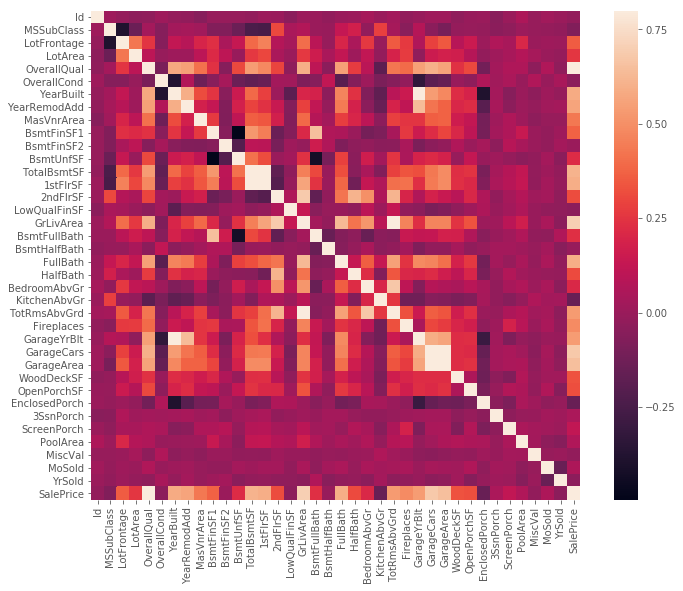

In [1546]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [1547]:
# get most correlated variables.

#print(corrmat[['SalePrice']])
abs_cormat = abs(corrmat[['SalePrice']])
abs_cormat = abs_cormat.sort_values(by = 'SalePrice', ascending=False)
list_correlations = abs_cormat.index.tolist()

most_correlated_20 = list_correlations[1:21]
print(most_correlated_20)

['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'LotArea']


In [1548]:
# add squared terms
#for var in most_correlated_20:
#    df_combined[var + '^2'] = df_combined[var] ** 2


# add interaction terms
#for i in range(len(most_correlated_20)):
    
#    for j in range(i+1,  len(most_correlated_20)):
#        df_combined[most_correlated_20[i] + most_correlated_20[j]] = df_combined[most_correlated_20[i]] * df_combined[most_correlated_20[j]]

In [1549]:

# log transformation of skewed variables.
skew_features = df_combined[num_variables].apply(lambda x: skew(x)).sort_values(ascending=False)

skew_features = skew_features[skew_features > 1]


for var in skew_features.index.tolist():
    df_combined[var] = np.log1p(df_combined[var])
    
df_combined['PoolQC'] = np.log1p(df_combined['PoolQC'])
    
print(df_combined[num_variables].apply(lambda x: skew(x)).sort_values(ascending=False))


PoolArea         15.623275
PoolQC           11.696086
3SsnPorch         8.822116
LowQualFinSF      8.554639
MiscVal           5.212005
BsmtHalfBath      3.773208
KitchenAbvGr      3.518883
ScreenPorch       2.944570
BsmtFinSF2        2.461259
EnclosedPorch     1.959952
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
TotRmsAbvGrd      0.749232
Fireplaces        0.725278
HalfBath          0.696666
TotalBsmtSF       0.671751
BsmtFullBath      0.622415
OverallCond       0.569314
MasVnrArea        0.538454
BedroomAbvGr      0.326568
MSSubClass        0.245930
GarageArea        0.218657
MoSold            0.197345
OverallQual       0.189591
FireplaceQu       0.173640
FullBath          0.165514
WoodDeckSF        0.159523
YrSold            0.131996
1stFlrSF          0.030358
Id               -0.000867
GrLivArea        -0.022051
OpenPorchSF      -0.041538
GarageCars       -0.218309
YearRemodAdd     -0.450134
LotArea          -0.532646
YearBuilt        -0.599194
G

# Create dummy variables for Categorical Features

In [1550]:
all_data = pd.get_dummies(df_combined, drop_first=True)
display(all_data.head(10))
print(all_data.shape)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,4,...,0,0,0,0,1,0,0,0,1,0
1,2,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,3,...,0,0,0,0,1,0,0,0,1,0
2,3,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,4,...,0,0,0,0,1,0,0,0,1,0
3,4,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,3,...,0,0,0,0,1,0,0,0,0,0
4,5,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,4,...,0,0,0,0,1,0,0,0,1,0
5,6,3.931826,4.454347,9.555064,5,5,1993,1995,0.000000,3,...,0,0,0,0,1,0,0,0,1,0
6,7,3.044522,4.330733,9.218804,8,5,2004,2005,5.231109,4,...,0,0,0,0,1,0,0,0,1,0
7,8,4.110874,4.394449,9.247925,7,6,1973,1973,5.484797,3,...,0,0,0,0,1,0,0,0,1,0
8,9,3.931826,3.951244,8.719481,7,5,1931,1950,0.000000,3,...,0,0,0,0,1,0,0,0,0,0
9,10,5.252273,3.931826,8.912069,5,6,1939,1950,0.000000,3,...,0,0,0,0,1,0,0,0,1,0


(2917, 207)


In [1551]:
# merge sale price back into training set
train_data = all_data.iloc[0 : len(df_train) -2]
train_data = train_data.merge(df_train[['Id',  'SalePrice']], on = 'Id')

print(train_data.shape)

target = train_data['SalePrice']
X = train_data.drop('SalePrice', axis = 1)

test_data = all_data.iloc[len(df_train) -2 :, ]
print(test_data.shape)

display(target.head())

train_data = train_data.set_index('Id')
test_data = test_data.set_index('Id')

train_data.to_csv('../cleaned_data/train_data_better_clean.csv')
test_data.to_csv('../cleaned_data/test_data_better_clean.csv')


(1458, 208)
(1459, 207)


0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64